In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from Utils.data_utils import load_train_test_data
from matplotlib import pyplot as plt
from pandas import Timestamp
import time
import pickle
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [3]:
(train_list, test_list), state_list = load_train_test_data(pwd)

In [4]:
#Creating lag value for each state '''probably not needed'''
for i in range(len(train_list)):
    train_list[i]['lag1'] = train_list[i]['carbon_per_MWh'].shift(24)
    train_list[i] = train_list[i].dropna()
    
for i in range(len(test_list)):
    test_list[i]['lag1'] = test_list[i]['carbon_per_MWh'].shift(24)
    test_list[i] = test_list[i].dropna()

In [5]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [6]:
def chunks(list_in, n):
    for i in range(0, len(list_in), n):
        yield list_in[i:i+n]

In [7]:
test_splitted_list = []
for i in range(len(test_list)):
    test_splitted_list.append(list(chunks(test_list[i], 168)))

In [8]:
NUMBER_OF_TEST_LISTS_PER_STATE = len(test_splitted_list[0])

In [9]:
texas_jan = np.array(test_splitted_list[0][0]['carbon_per_MWh'])
texas_train = np.array(train_list[0]['carbon_per_MWh'])

In [10]:
texas_train.shape

(30596,)

In [11]:
np.hstack((texas_train,texas_jan)).shape

(30764,)

In [12]:
predictions = []
errors = []
for train, test_splitted in zip(train_list, test_splitted_list):
    train_features = np.array(train['lag1'])
    train_labels = np.array(train['carbon_per_MWh'])
    for i,test in enumerate(test_splitted):
        start = time.time()
        test_features = np.array(test['lag1'])
        test_labels = np.array(test['carbon_per_MWh'])
        rf.fit(train_features.reshape(-1,1), train_labels)
        prediction = rf.predict(test_features.reshape(-1,1))
        predictions.append(prediction)
        errors.append(abs(prediction - test_labels))
        train_features = np.hstack((train_features, test_features))
        train_labels = np.hstack((train_labels, test_labels))
        end = time.time()
        print(f"Iter {i+1} done. Time: {(end-start):.2f}")

Iter 1 done. Time: 26.13
Iter 2 done. Time: 25.85
Iter 3 done. Time: 26.06
Iter 4 done. Time: 26.25
Iter 5 done. Time: 26.39
Iter 6 done. Time: 26.61
Iter 7 done. Time: 26.89
Iter 8 done. Time: 27.49
Iter 9 done. Time: 28.25
Iter 10 done. Time: 27.57
Iter 11 done. Time: 28.00
Iter 12 done. Time: 28.24
Iter 13 done. Time: 28.58
Iter 14 done. Time: 28.97
Iter 15 done. Time: 29.04
Iter 16 done. Time: 29.58
Iter 17 done. Time: 29.33
Iter 18 done. Time: 31.79
Iter 19 done. Time: 30.07
Iter 1 done. Time: 22.34
Iter 2 done. Time: 22.58
Iter 3 done. Time: 22.74
Iter 4 done. Time: 22.56
Iter 5 done. Time: 22.64
Iter 6 done. Time: 22.75
Iter 7 done. Time: 22.81
Iter 8 done. Time: 22.90
Iter 9 done. Time: 22.99
Iter 10 done. Time: 23.12
Iter 11 done. Time: 23.82
Iter 12 done. Time: 23.60
Iter 13 done. Time: 23.87
Iter 14 done. Time: 24.49
Iter 15 done. Time: 24.64
Iter 16 done. Time: 24.92
Iter 17 done. Time: 24.95
Iter 18 done. Time: 25.26
Iter 19 done. Time: 25.47
Iter 1 done. Time: 21.98
Iter 

In [23]:
merged_predictions = []
for i in predictions:
    merged_predictions.extend(i)

In [14]:
merged_errors = []
for i in range(0, len(errors), NUMBER_OF_TEST_LISTS_PER_STATE):
    temp_list = []
    for j in range(i, i+NUMBER_OF_TEST_LISTS_PER_STATE):
        temp_list.extend(errors[j])
    merged_errors.append(temp_list)

In [16]:
for state, error in zip(state_list, merged_errors):
    print(f"MAE for {state} = {np.mean(error)}")

MAE for Texas = 74.95053683619057
MAE for Carolinas = 29.443458842858153
MAE for Florida = 14.242611352763054
MAE for Southeast = 19.16515196801303
MAE for Tennessee = 24.31906805103428
MAE for Central = 115.90555858473996
MAE for Southwest = 23.37430582183374
MAE for Midwest = 46.63086206737909
MAE for New-York = 22.521880841554108
MAE for Mid-Atlantic = 22.882190717980144
MAE for New-England = 32.88619437885369
MAE for California = 29.34034859833492
MAE for Northwest = 32.640808458855695


In [17]:
len(predictions)

247

In [18]:
merged_predictions = []
for i in range(0,len(predictions),NUMBER_OF_TEST_LISTS_PER_STATE):
    temp_list = []
    for j in range(i, i+NUMBER_OF_TEST_LISTS_PER_STATE):
        temp_list.extend(predictions[j])
    merged_predictions.append(temp_list)

In [19]:
len(merged_predictions[0])

3149

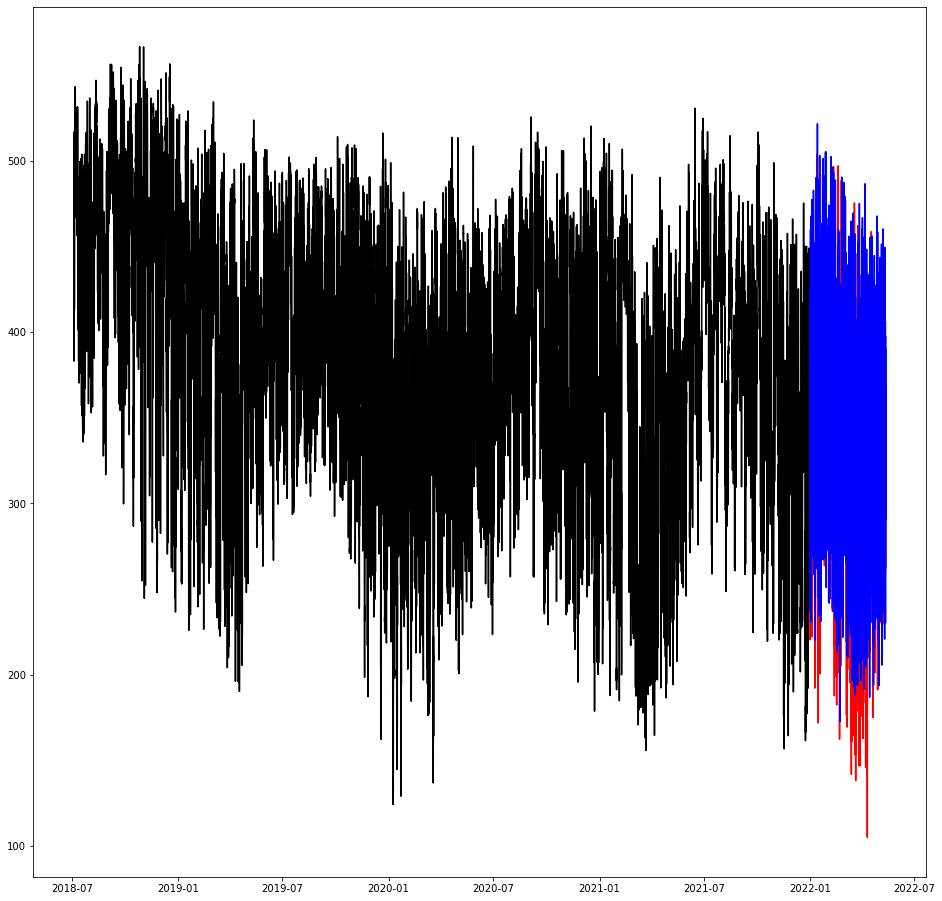

In [20]:
plt.figure(figsize=(16,16))
plt.plot(train_list[0].index, train_list[0]['carbon_per_MWh'], color='black')
plt.plot(test_list[0].index, test_list[0]['carbon_per_MWh'], color='red')
plt.plot(test_list[0].index, merged_predictions[0], color='blue')

In [43]:
hour_dict_list = []
for i in range(len(test_list)):
    hour_dict = {test_list[i].index[j] : merged_predictions[i][j] for j in range(len(merged_predictions[i]))}
    hour_dict_list.append(hour_dict)

In [44]:
file = open(f'{pwd}/data/predictions/rfpred_retrain.pkl', 'wb')
pickle.dump(hour_dict_list, file)
file.close()

In [41]:
predictions[1][2]

418.4542222239573

In [42]:
merged_predictions[1][2]

181.92816668753758

In [24]:
hour_dict_list

[{Timestamp('2022-01-01 01:00:00+0000', tz='UTC'): 351.5834654891577,
  Timestamp('2022-01-01 02:00:00+0000', tz='UTC'): 397.51372329255577,
  Timestamp('2022-01-01 03:00:00+0000', tz='UTC'): 341.85007979228106,
  Timestamp('2022-01-01 04:00:00+0000', tz='UTC'): 325.66013535325476,
  Timestamp('2022-01-01 05:00:00+0000', tz='UTC'): 332.7567225294696,
  Timestamp('2022-01-01 06:00:00+0000', tz='UTC'): 389.96174352247016,
  Timestamp('2022-01-01 07:00:00+0000', tz='UTC'): 237.45873806424447,
  Timestamp('2022-01-01 08:00:00+0000', tz='UTC'): 402.51285977031824,
  Timestamp('2022-01-01 09:00:00+0000', tz='UTC'): 341.3266918959573,
  Timestamp('2022-01-01 10:00:00+0000', tz='UTC'): 362.7385769220347,
  Timestamp('2022-01-01 11:00:00+0000', tz='UTC'): 265.28868290275426,
  Timestamp('2022-01-01 12:00:00+0000', tz='UTC'): 349.16374309752223,
  Timestamp('2022-01-01 13:00:00+0000', tz='UTC'): 316.0384469441614,
  Timestamp('2022-01-01 14:00:00+0000', tz='UTC'): 375.01728169296445,
  Timestamp

In [28]:
hour_dict_list[0]

{Timestamp('2022-01-01 01:00:00+0000', tz='UTC'): 351.5834654891577,
 Timestamp('2022-01-01 02:00:00+0000', tz='UTC'): 397.51372329255577,
 Timestamp('2022-01-01 03:00:00+0000', tz='UTC'): 341.85007979228106,
 Timestamp('2022-01-01 04:00:00+0000', tz='UTC'): 325.66013535325476,
 Timestamp('2022-01-01 05:00:00+0000', tz='UTC'): 332.7567225294696,
 Timestamp('2022-01-01 06:00:00+0000', tz='UTC'): 389.96174352247016,
 Timestamp('2022-01-01 07:00:00+0000', tz='UTC'): 237.45873806424447,
 Timestamp('2022-01-01 08:00:00+0000', tz='UTC'): 402.51285977031824,
 Timestamp('2022-01-01 09:00:00+0000', tz='UTC'): 341.3266918959573,
 Timestamp('2022-01-01 10:00:00+0000', tz='UTC'): 362.7385769220347,
 Timestamp('2022-01-01 11:00:00+0000', tz='UTC'): 265.28868290275426,
 Timestamp('2022-01-01 12:00:00+0000', tz='UTC'): 349.16374309752223,
 Timestamp('2022-01-01 13:00:00+0000', tz='UTC'): 316.0384469441614,
 Timestamp('2022-01-01 14:00:00+0000', tz='UTC'): 375.01728169296445,
 Timestamp('2022-01-01 15

In [25]:
temp = pickle.load(open(f'{pwd}/data/predictions/rfpred_retrain.pkl', 'rb'))

In [27]:
temp[0]

{Timestamp('2022-01-01 01:00:00+0000', tz='UTC'): 351.5834654891577,
 Timestamp('2022-01-01 02:00:00+0000', tz='UTC'): 397.51372329255577,
 Timestamp('2022-01-01 03:00:00+0000', tz='UTC'): 341.85007979228106,
 Timestamp('2022-01-01 04:00:00+0000', tz='UTC'): 325.66013535325476,
 Timestamp('2022-01-01 05:00:00+0000', tz='UTC'): 332.7567225294696,
 Timestamp('2022-01-01 06:00:00+0000', tz='UTC'): 389.96174352247016,
 Timestamp('2022-01-01 07:00:00+0000', tz='UTC'): 237.45873806424447,
 Timestamp('2022-01-01 08:00:00+0000', tz='UTC'): 402.51285977031824,
 Timestamp('2022-01-01 09:00:00+0000', tz='UTC'): 341.3266918959573,
 Timestamp('2022-01-01 10:00:00+0000', tz='UTC'): 362.7385769220347,
 Timestamp('2022-01-01 11:00:00+0000', tz='UTC'): 265.28868290275426,
 Timestamp('2022-01-01 12:00:00+0000', tz='UTC'): 349.16374309752223,
 Timestamp('2022-01-01 13:00:00+0000', tz='UTC'): 316.0384469441614,
 Timestamp('2022-01-01 14:00:00+0000', tz='UTC'): 375.01728169296445,
 Timestamp('2022-01-01 15